<a href="https://colab.research.google.com/github/lamtranBKHN/FaceDetector/blob/master/LittleDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Thêm thư viện
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
import numpy as np
import random
import os
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
import cv2
import pickle

Using TensorFlow backend.


In [0]:
IMG_SIZE = 224

file_list = []
class_list = []

DATADIR = "cropped_Face"

# All the categories neural network will detect
CATEGORIES = ["Avicii", "Charlie_Puth","Den_Vau","Adam_Levine","Adele"]

# Checking or all images in the data folder
for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()
random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)   
# Creating the files containing all the information about your model
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0         

In [0]:
#from keras.utils import to_categorical
#y = to_categorical(y)
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected lay
baseModel = VGG16(weights='imagenet', include_top=False, \
                  input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
# Buil layer
fcHead = baseModel.output
# Flatten 
fcHead = Flatten()(fcHead)
# Add FC
fcHead = Dense(64, activation='relu')(fcHead)
fcHead = Dropout(0.5)(fcHead)
# Output layer with softmax activation
fcHead = Dense(5, activation='softmax')(fcHead)
# modle
model = model = Model(inputs=baseModel.input, outputs=fcHead)

Train on 220 samples, validate on 25 samples
Epoch 1/500
220/220 [==============================] - 6s 30ms/step - loss: 0.6944 - accuracy: 0.8000 - val_loss: 0.8918 - val_accuracy: 0.7200
Epoch 2/500
220/220 [==============================] - 6s 28ms/step - loss: 0.6957 - accuracy: 0.7955 - val_loss: 0.8832 - val_accuracy: 0.7600
Epoch 3/500
220/220 [==============================] - 6s 28ms/step - loss: 0.6647 - accuracy: 0.7773 - val_loss: 0.8779 - val_accuracy: 0.8000
Epoch 4/500
220/220 [==============================] - 6s 28ms/step - loss: 0.6415 - accuracy: 0.8091 - val_loss: 0.8658 - val_accuracy: 0.8000
Epoch 5/500
220/220 [==============================] - 6s 28ms/step - loss: 0.5861 - accuracy: 0.8455 - val_loss: 0.8584 - val_accuracy: 0.7600
Epoch 6/500
220/220 [==============================] - 6s 28ms/step - loss: 0.6219 - accuracy: 0.7955 - val_loss: 0.8435 - val_accuracy: 0.8000
Epoch 7/500
220/220 [==============================] - 6s 28ms/step - loss: 0.5893 - accura

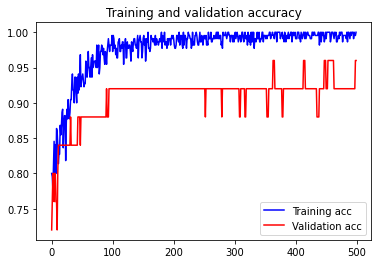

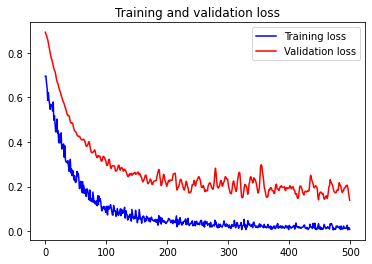

In [6]:
model.compile(loss = "sparse_categorical_crossentropy", 
                    optimizer = SGD(lr=1e-5, momentum=0.9), 
                    metrics=["accuracy"])
# Training the model.
X = np.array(X)
y = np.array(y)
history = model.fit(X, y, batch_size=32, epochs=500, validation_split=0.1)
'''
history = model.fit_generator(aug_train.flow(X, y, batch_size=32),
                              steps_per_epoch=len(X)//32,
                              validation_data=(aug_test.flow(X, y, batch_size=32)),
                              validation_steps=len(X)//32,
                              epochs=50)
'''
# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
    json_file.write(model_json)

model.save_weights("model2.h5")
print("Saved model to disk")

model.save('CNN2.model')

# Printing a graph showing the accuracy changes during the training phase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
import tensorflow as tf
model = tf.keras.models.load_model("CNN2.model")

def test(filename, required_size=(IMG_SIZE, IMG_SIZE)):
    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width+ width//6, y1 + height + height//6

    if y1 > height//6:
      y1_new = y1 - height//6
    else:
      y1_new = y1
    if x1 > width//6:
      x1_new = x1 - width//6
    else:
      x1_new = x1
  
    # extract the face
    face = pixels[y1_new:y2, x1_new:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    # face_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    new_array = cv2.resize(face_array, (IMG_SIZE, IMG_SIZE)) 
    new_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    prediction = model.predict([new_array])
    prediction = list(prediction[0])
    # get dimensions of image
    dimensions = pixels.shape
    height_IN = pixels.shape[0]
    width_IN = pixels.shape[1]

    cv2.putText(pixels,CATEGORIES[prediction.index(max(prediction))],
                (0,height_IN), 0, (width_IN)//200, 
                (255, 0, 255),height_IN//100, cv2.LINE_AA)
    
    pixels = cv2.rectangle(pixels,(x1_new,y1_new),
                           (x1 + width+ width//6,y1 + height + height//6),
                           (255,0,0),2)
    plt.imshow(pixels) 
    plt.show()
    print(prediction[prediction.index(max(prediction))]*100, '%')
    #return new_array



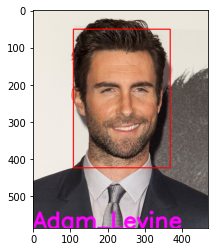

100.0 %


In [8]:
test('test_Adam1.jpg')

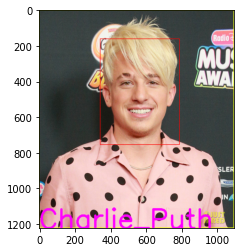

100.0 %


In [9]:
test('test_Charlie.jpg')

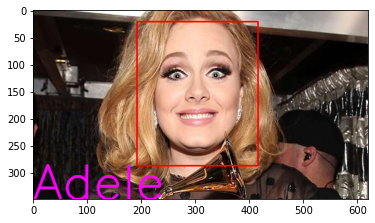

100.0 %


In [11]:
test('test_Adele2.jpg')

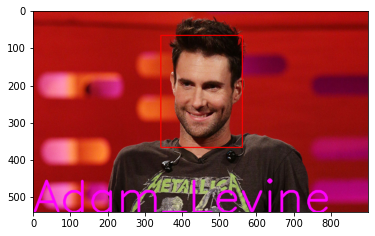

99.99749660491943 %


In [13]:
test('test_Adam3.jpg')

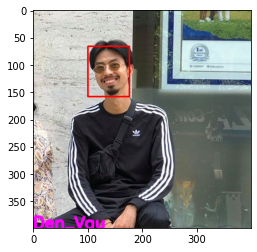

99.95675683021545 %


In [15]:
test('test_Den2.jpg')

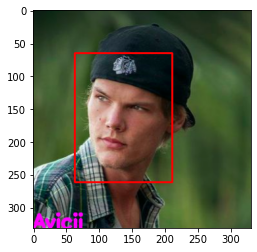

100.0 %


In [16]:
test('test_Avicii3.jpg')

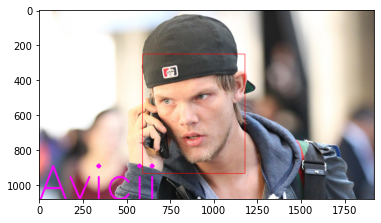

100.0 %


In [17]:
test('test_Avicii4.jpg')

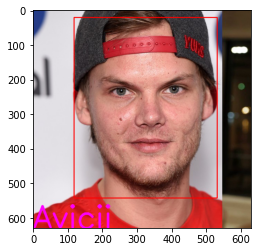

100.0 %


In [18]:
test('test_Avicii5.jpg')

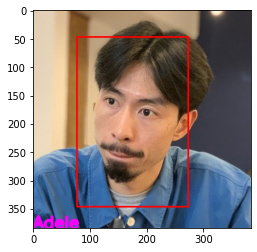

100.0 %


In [20]:
test('test-Den10.jpg')

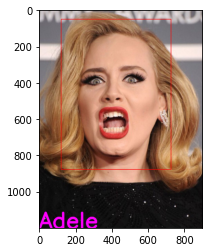

100.0 %


In [22]:
test('tes_Adele3.jpg')

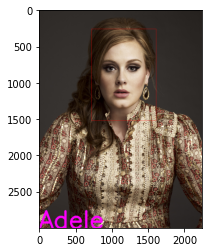

100.0 %


In [23]:
test('1.jpg')